<h1><b>DEEP LEARNING PROJECT</b></h1>

<h2><b><i>Classifying Traffic Signs Using ESRGAN & CNN Models</i></b></h2>

<p>The goal of this project is to classify different traffic signs using their images. For this purpose, two deep learning models are used, ESRGAN (Enhanced Super-Resolution Generative Adversarial Network) and CNN (Convolutional Neural Network). The ESRGAN model is used to enhance and upscale the quality of train images and then these upscaled images are then provided as input to the CNN model for training purpose.</p>
<p>The dataset used in this project is none other than the famous GTSRB (German Traffic Sign Recognition Benchmark) dataset which contains 50 thousand images of 43 different traffic signs. The dataset has been downloaded from kaggle (link is provided) and is imported using ImageDataGenerator from keras. The models are evaluated on the basis of their validation accuracies and validation losses.</p>

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import tensorflow_hub as hub
import os
import cv2
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # type:ignore
from tensorflow.keras.models import Sequential   # type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout   # type:ignore
from tensorflow.keras.optimizers import Adam    # type:ignore
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Checking what resources are available for this project
print("Number of GPUs Available:", len(tensorflow.config.list_physical_devices('GPU')))
print("Number of CPUs Available:", len(tensorflow.config.list_physical_devices('CPU')))

Number of GPUs Available: 0
Number of CPUs Available: 1


In [4]:
# Setting the path of GTSRB train and test images dataset
train_dataset_path = '..\\Datasets\\GTSRB Dataset\\Train\\'
test_dataset_path = '..\\Datasets\\GTSRB Dataset\\Test\\'

In [5]:
# Setting the mapping of 43 classes of GTSRB dataset
classes = {
    0: 'Speed Limit (20 km/h)',
    1: 'Speed Limit (30 km/h)',
    2: 'Speed Limit (50 km/h)',
    3: 'Speed Limit (60 km/h)',
    4: 'Speed Limit (70 km/h)',
    5: 'Speed Limit (80 km/h)',
    6: 'End of Speed Limit (80 km/h)',
    7: 'Speed Limit (100 km/h)',
    8: 'Speed Limit (120 km/h)',
    9: 'No Passing',
    10: 'No Passing for Vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority Road',
    13: 'Yield',
    14: 'Stop',
    15: 'No Vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No Entry',
    18: 'General Caution',
    19: 'Dangerous Curve to the left',
    20: 'Dangerous Curve to the right',
    21: 'Double Curve',
    22: 'Bumpy Road',
    23: 'Slippery Road',
    24: 'Road Narrows on the Right',
    25: 'Road Work',
    26: 'Traffic Signals',
    27: 'Pedestrians',
    28: 'Children Crossing',
    29: 'Bicycles Crossing',
    30: 'Beware of Ice/Snow',
    31: 'Wild Animals Crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

-> The dataset has following structure:
<p><li><b>Train Directory:</b> It consist of approximately 40 thousand images of traffic signs on which the model is trained. This directory is subdivided into sub-directories which are named after their class id.</li>
<li><b>Test Directory:</b> It consist of approximately 10 thousand images of traffic signs on which the model is tested.</li>
<li><b>Meta Directory:</b> It consist of 43 images, one for each class.</li>
<li><b>Train.csv:</b> It consist of the data about training images, their height, widht, class id and path.</li>
<li><b>Test.csv:</b> It consist of the data about test images, their height, widht, class id and path.</li>
<li><b>Meta.csv:</b> It consist of the data about meta images, their sign id, class id and path.</li>
<br><br>
There are total 43 classes of traffic signs in this dataset in which these images are to be classified. These are mapped with their labels in the above created dictionary.
</p>

<h2>Loading the Dataset</h2>

In [6]:
# Preprocessing and loading the training part of train dataset
train_datagen = ImageDataGenerator(
    rescale = 1.0/255, 
    validation_split=0.2)

train_dataset = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size = (32, 32),
    batch_size = 4,
    class_mode = 'categorical',
    shuffle = True,
    color_mode = 'rgb',
    subset = 'training'
)

# Preprocessing and loading the validation part of train dataset
val_dataset = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size = (32, 32),
    batch_size = 4, 
    class_mode = 'categorical',
    shuffle = True,
    color_mode = 'rgb',
    subset = 'validation'
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


-> The whole training dataset is divided into training and validation data with a split of 20% (out of total 40,000 images, 20% are being used for the validation purposes). These images are loaded and preprocessed according to the requirements.

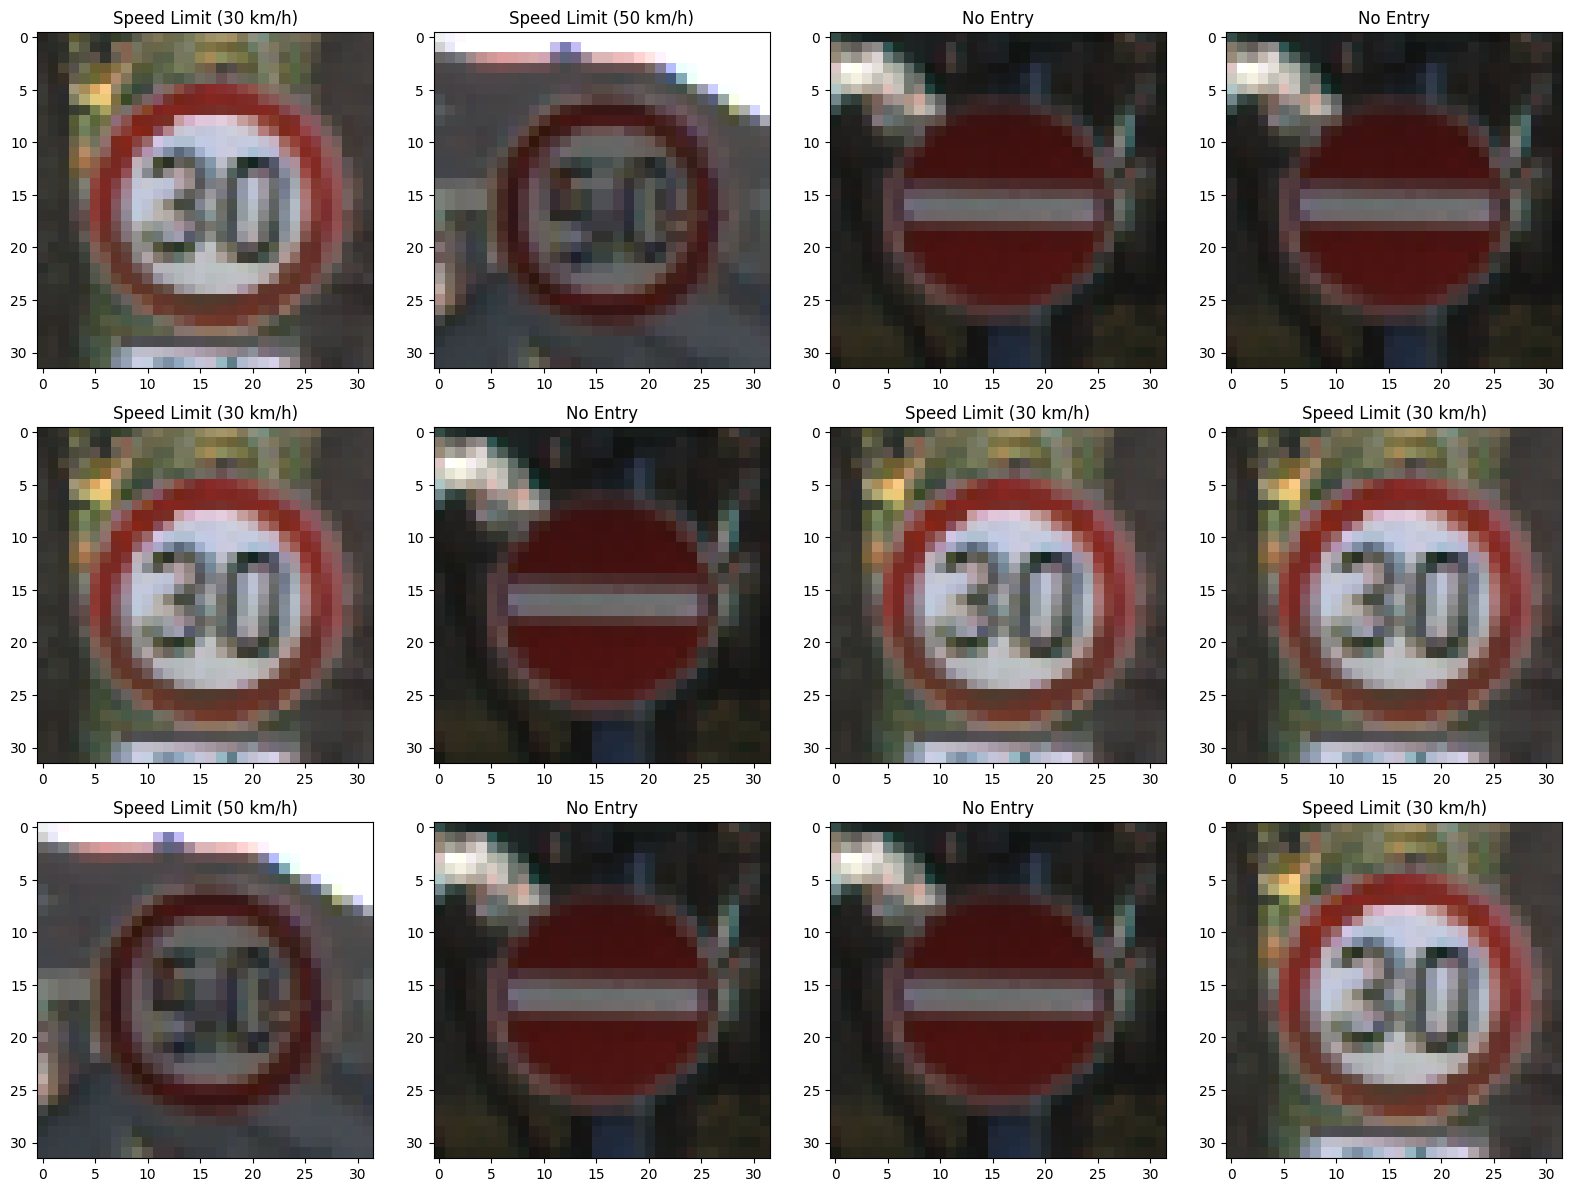

In [7]:
# Showing some of the images
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# Get a batch of data
img, y = next(iter(train_dataset))

for i in range(3):
    for j in range(4):
        rand = np.random.randint(0, img.shape[0])
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[rand])])]
        ax[i, j].imshow(img[rand])
        ax[i, j].set_title(label)

plt.tight_layout()
plt.show()


-> The images currently very dull. These are very low scale images (32x32) which can be difficult to be classified by CNN model. To address this issue, I'll use <b>ESRGAN super-resolution model</b> to upscale and enhance the quality of these images so that it would be easier for CNN to identify and classify these images.

## <b>Using Pre-Trained ESRGAN Model</b>

In [8]:
# Loading the pre-trained ESRGAN model from tensorflow hub.
ESRGAN_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")   # type:ignore

In [9]:
# Defining a function to apply ESRGAN model to enhance the quality of images
def enhance_images(images):
    images = images * 2.0 - 1.0  # Rescale the entire batch to [-1, 1]
    enhanced_images = ESRGAN_model(images)  # Enhance the batch
    enhanced_images = (enhanced_images + 1.0) / 2.0  # Rescale back to [0, 1]
    enhanced_images = np.clip(enhanced_images, 0, 1)  # Clip values to [0, 1]
    return enhanced_images

In [10]:
# Making a directory to save the enhanced images
os.makedirs('..\\Datasets\\GTSRB Dataset\\Enhanced Train', exist_ok=True)

In [11]:
# Saving enhanced images to the correct subdirectory based on their class
def save_enhanced_images(enhanced_batch, label, class_indices, start_index):
    for i, img in enumerate(enhanced_batch):
        # Get the class label for current image
        class_idx = np.argmax(label[i])
        class_label = list(class_indices.keys())[class_idx]  

        # Create the class subdirectory if it doesn't exist
        class_dir = os.path.join('..\\Datasets\\GTSRB Dataset\\Enhanced Train', class_label)
        os.makedirs(class_dir, exist_ok=True)

        # Convert image from float [0, 1] to uint8 [0, 255]
        img_uint8 = (img * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8)
        
        # Save the image in the class subdirectory with a unique name
        img_pil.save(os.path.join(class_dir, f"enhanced_image_{start_index + i}.png"), quality=95)

-> The idea of these functions is that the original images in the dataset will be divided into batch of 4 and preprocessed. Then these images will be provided to the pre-trained ESRGAN model to upscale them. Since there are 40,000 images and upscaling them will hold a lot of memory, we can't just hold them inside RAM. So, save_enhanced_images() function is used to save these images inside 'Enhanced Train' folder in the same structure as of 'Train' folder.

In [ ]:
# Enhancing images in the dataset
enhanced_imgs = []
start_index = 0
i=0

for img_batch, labels in train_dataset:
    imgs_resized = tensorflow.image.resize(img_batch, [128, 128], method=tensorflow.image.ResizeMethod.BICUBIC)  # Resize to 128x128
    enhanced_batch = enhance_images(imgs_resized)  # Apply ESRGAN

    # Save enhanced images to the respective class subdirectories
    save_enhanced_images(enhanced_batch, labels, train_dataset.class_indices, start_index)  

    # Update start_index to ensure unique names for each batch of images
    start_index += len(enhanced_batch)

    # Clear memory
    del img_batch, enhanced_batch
    tensorflow.keras.backend.clear_session()

-> This piece of code upscaled all the original images. Now the images are of 128x128 resolution with improved quality. The output of this cell is not shown since it took more than 10 hrs to execute this cell and due to some bug (which is not identified yet), this cell kept on running even after the number of enhanced images exceeded training images. So, I interrupted this cell. There was no loss since all the images are being saved inside the 'Enhanced Train' directory.

In [12]:
# Preprocessing and loading the enhanced train dataset
enhanced_train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.2
)

enhanced_train_dataset = enhanced_train_datagen.flow_from_directory(
    '..\\Datasets\\GTSRB Dataset\\Enhanced Train',
    target_size = (128, 128), 
    batch_size = 4, 
    class_mode = 'categorical',
    shuffle = True,
    color_mode = 'rgb',
    subset = 'training'
)

# Preprocessing and loading the validation part of enhanced train dataset
enhanced_val_dataset = enhanced_train_datagen.flow_from_directory(
    '..\\Datasets\\GTSRB Dataset\\Enhanced Train',
    target_size = (128, 128),
    batch_size = 4,
    class_mode = 'categorical',
    shuffle = True,
    color_mode = 'rgb',
    subset = 'validation'
)

Found 32123 images belonging to 43 classes.
Found 8013 images belonging to 43 classes.


-> This number here shows that there are more number of images in the 'Enhanced Train' directory than were in 'Train' directory. Anyways, the structure here is also same with 20% of the enhanced training images being used as validation images. 

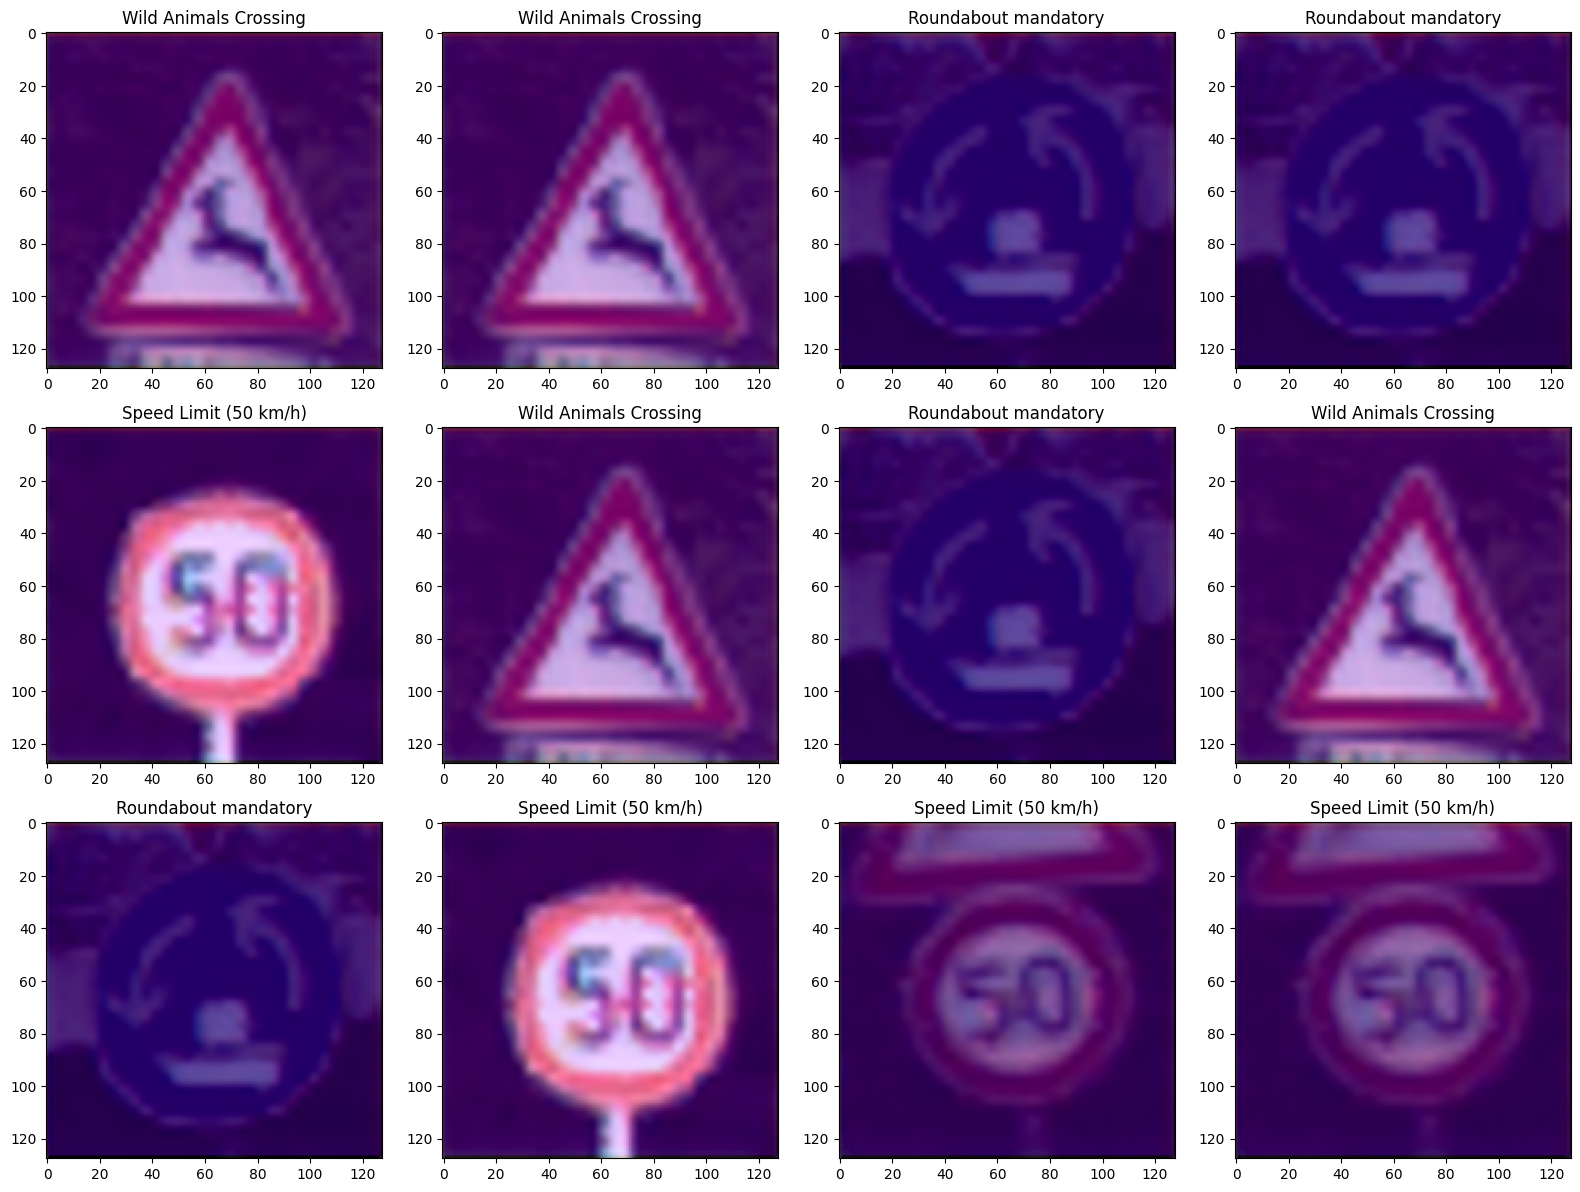

In [13]:
# Showing some of the enhanced images
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# Get a batch of data
img, y = next(iter(enhanced_train_dataset))

for i in range(3):
    for j in range(4):
        rand = np.random.randint(0, img.shape[0])
        label = classes[int(list(enhanced_train_dataset.class_indices.keys())[np.argmax(y[rand])])]
        ax[i, j].imshow(img[rand])
        ax[i, j].set_title(label)

plt.tight_layout()
plt.show()


## <b>Training the CNN Model</b>

In [14]:
# Creating the CNN architecture
CNN_model = Sequential()

# Convolution Layers
CNN_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)))   # 128x128 size image with 3 channels (rgb)
CNN_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.3))

CNN_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.3))

CNN_model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.3))

# Flatten Layer
CNN_model.add(Flatten())

# Fully Connected Layer
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.5))

CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dropout(0.5))

# Final output layer
CNN_model.add(Dense(43, activation='softmax'))

In [15]:
# Printing the summary of the model
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,995 (10.03 MB)

 Trainable params: 2,629,547 (10.03 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Compiling the model
CNN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Training the model
history = CNN_model.fit(enhanced_train_dataset, epochs=10, batch_size=4, validation_data=enhanced_val_dataset)

Epoch 1/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 697s 86ms/step - accuracy: 0.2136 - loss: 3.4359 - val_accuracy: 0.7525 - val_loss: 1.0113
Epoch 2/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 833s 104ms/step - accuracy: 0.5795 - loss: 1.4809 - val_accuracy: 0.8643 - val_loss: 0.5434
Epoch 3/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 889s 111ms/step - accuracy: 0.7077 - loss: 0.9794 - val_accuracy: 0.9491 - val_loss: 0.2694
Epoch 4/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 937s 117ms/step - accuracy: 0.7892 - loss: 0.7158 - val_accuracy: 0.9689 - val_loss: 0.1793
Epoch 5/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 860s 107ms/step - accuracy: 0.8354 - loss: 0.5634 - val_accuracy: 0.9669 - val_loss: 0.1622
Epoch 6/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 906s 113ms/step - accuracy: 0.8640 - loss: 0.4576 - val_accuracy: 0.9854 - val_loss: 0.0754
Epoch 7/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 846s 105ms/step - accuracy: 0.8848 - loss: 0.3853 - val_accuracy: 0.9895 - val_loss: 0.0702
Epoch 8/10
8031/8031 ━━━━━━━━━━━━━━━━━━━━ 879s 109ms/step - acc

-> After training the CNN model, we can see that it has reached good accuracy of 0.91 with 0.28 loss. The validation accuracy is much higher (0.98) and so is validation loss (much low - 0.13). This is due to the fact that using dropouts make the training process harder for the model. That's why it achieved a good validation accuracy and succeeded in minimizing validation loss.

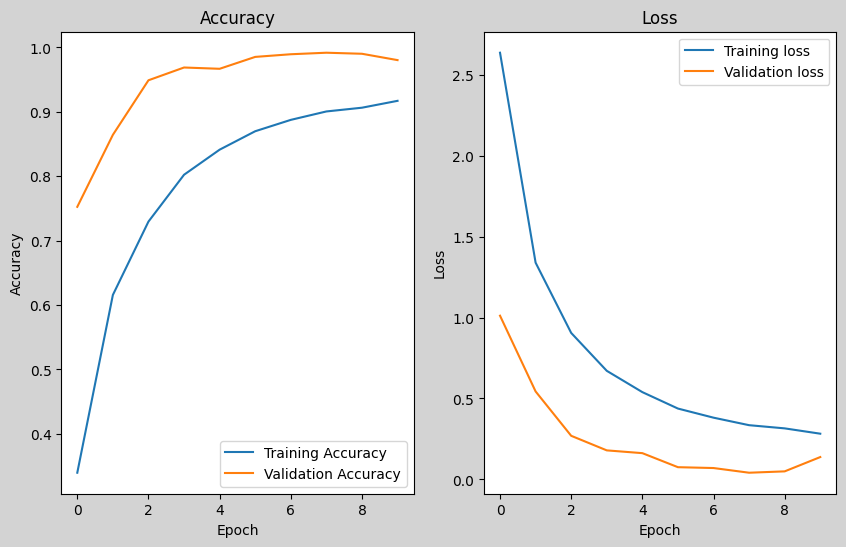

In [56]:
# Plotting the training and validation accuracies and losses
plt.figure(figsize=(10, 6), facecolor='lightgray')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

-> From the graphs, this can be seen that:
<br>
- As the number of epochs increases, both training and validation accuracies increases but at highest epochs, the validation accuracy slightly start decreasing, indicating that further training will make the model to overfit to the training data.
- As the number of epochs increases, both training and validation losses decreases in the same fashion. Overfitting sign can also be seen here, since at highest epoch number, the validation loss start to incrase a bit, indicating the danger of overfitting.

In [37]:
# Evaluating the model
train_score = CNN_model.evaluate(enhanced_train_dataset)
val_score = CNN_model.evaluate(enhanced_val_dataset)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", val_score[0])
print("Validation Accuracy: ", val_score[1])

8031/8031 ━━━━━━━━━━━━━━━━━━━━ 455s 57ms/step - accuracy: 0.9859 - loss: 0.1181
2004/2004 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - accuracy: 0.9817 - loss: 0.1369
Train Loss:  0.11842001974582672
Train Accuracy:  0.9862715005874634
--------------------
Validation Loss:  0.13799241185188293
Validation Accuracy:  0.9804068207740784


## Saving the Models

In [60]:
# Saving both the ESRGAN and CNN models for model deployment step
tensorflow.saved_model.save(ESRGAN_model, 'Models/ESRGAN_Model')
CNN_model.save('Models/CNN_Model.h5')

INFO:tensorflow:Assets written to: Models/ESRGAN_Model\assets


INFO:tensorflow:Assets written to: Models/ESRGAN_Model\assets


## Making Prediction

In [103]:
# Making a function to map predictions to the labels
def map_pred(pred):
    return classes[pred]

In [78]:
# Loading the test csv file
test_df = pd.read_csv('..\\Datasets\\GTSRB Dataset\\Test.csv')
test_df.head(4)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png


In [203]:
# Load and preprocess a single test image
def preprocess_test_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    resized_image = tensorflow.image.resize(image, [128, 128], method=tensorflow.image.ResizeMethod.BICUBIC)
    normalized_image = resized_image / 255.0
    return normalized_image

In [204]:
# Load and enhance the test image
def enhance_test_image(image):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    enhanced_image = enhance_images(image)  # Apply ESRGAN
    enhanced_image = np.squeeze(enhanced_image, axis=0)  # Remove batch dimension
    return enhanced_image

In [205]:
# Example code to visualize predictions
def visualize_predictions(image_path, true_label):
    try:
        image = preprocess_test_image(image_path)
        enhanced_image = enhance_test_image(image)
        X_test = (enhanced_image * 255).astype(np.uint8)
        X_test = cv2.resize(X_test, (128, 128)) / 255.0

        plt.imshow(X_test)
        plt.title(f"True Label: {true_label}")
        plt.show()

        # Make prediction
        X_test = np.expand_dims(X_test, axis=0)
        pred = CNN_model.predict(X_test)
        pred_class = np.argmax(pred)
        predicted_class = map_pred(pred_class)
        print(f"Predicted Class: {predicted_class}")

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

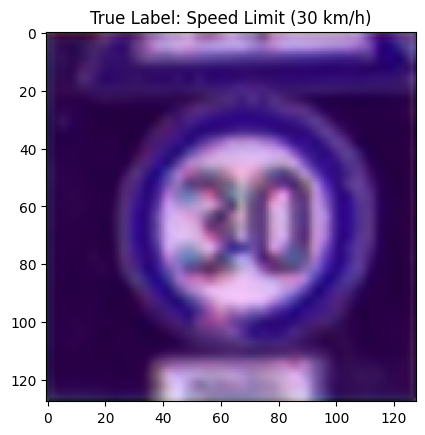

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Class: Go straight or left


In [216]:
# Load test CSV and process a random image
test_df = pd.read_csv('..\\Datasets\\GTSRB Dataset\\Test.csv')
test_labels = test_df['ClassId'].values
imgs = test_df['Path'].values
random_index = rn.randint(0, len(imgs) - 1)
random_image_path = '..\\Datasets\\GTSRB Dataset\\' + imgs[random_index]
true_label = classes[test_labels[random_index]]

visualize_predictions(random_image_path, true_label)

-> For prediction, first an image is selected randomly using the test.csv file. Then this image is passed through the same preprocessing and enhancing steps as of training images. Then these images are provided to the CNN model which gave its prediction on the image.

<hr>